In [1]:
import pymc3 as pm
import numpy as np
import theano
import theano.tensor as tt
import arviz as az
import matplotlib.pyplot as plt

from tvb.simulator.lab import *
from tvb_inversion.base.observation_models import linear
from tvb_inversion.pymc3.prior import Pymc3Prior
from tvb_inversion.pymc3.stats_model import Pymc3Model
from tvb_inversion.pymc3.inference import EstimatorPYMC
from tvb_inversion.pymc3.stats_model_builder import StochasticPymc3ModelBuilder
from tvb_inversion.pymc3.plot import plot_posterior_samples

%load_ext autoreload
%autoreload 2
%matplotlib inline

/Users/erichter/Documents/Uni/Charite/tvb-backend/tvb-root/tvb_library/tvb/datatypes/surfaces.py:64: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [2]:
#conn = connectivity.Connectivity.from_file()
conn = connectivity.Connectivity()
conn.weights = np.array([[0., 2.], [2., 0.]])
conn.region_labels = np.array(["R1", "R2"])
conn.centres = np.array([[0.1, 0.1, 0.1], [0.2, 0.1, 0.1]])
conn.tract_lengths = np.array([[0., 2.5], [2.5, 0.]])
conn.configure()

sim = simulator.Simulator(
    model=models.oscillator.Generic2dOscillator(a=np.array([1.5])),
    connectivity=conn,
    coupling=coupling.Difference(),
    integrator=integrators.HeunStochastic(
        dt=1.0,
        noise=noise.Additive(
            nsig=np.array([1e-4]),
            noise_seed=42
        )
    ),
    monitors=[monitors.Raw()],
    simulation_length = 250
)

In [3]:
sim.configure()

,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity gid: 9680b584-a310-4d57-9d71-5fa130b6f741
coupling,Difference gid: 82a78bd3-367b-4e25-91c9-1886eb319c33
gid,UUID('0816804c-81ce-4287-8eb4-c0708db27188')
initial_conditions,None
integrator,HeunStochastic gid: 5bcd4745-b2cd-41ab-91e3-8aa8a90346e4
model,Generic2dOscillator gid: b5bac0cf-872d-4cb6-8e9a-b320fbf93f9a
monitors,[]
simulation_length,250.0


In [4]:
sim.initial_conditions = np.zeros((conn.horizon, sim.model.nvar, conn.number_of_regions, 1))

In [5]:
sim.configure()

,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity gid: 9680b584-a310-4d57-9d71-5fa130b6f741
coupling,Difference gid: 82a78bd3-367b-4e25-91c9-1886eb319c33
gid,UUID('0816804c-81ce-4287-8eb4-c0708db27188')
"initial_conditions [min, median, max]","[0, 0, 0]"
initial_conditions dtype,float64
initial_conditions shape,"(2, 2, 2, 1)"
integrator,HeunStochastic gid: 5bcd4745-b2cd-41ab-91e3-8aa8a90346e4
model,Generic2dOscillator gid: b5bac0cf-872d-4cb6-8e9a-b320fbf93f9a


In [6]:
(t, X), = sim.run()

In [7]:
X.shape

(250, 2, 2, 1)

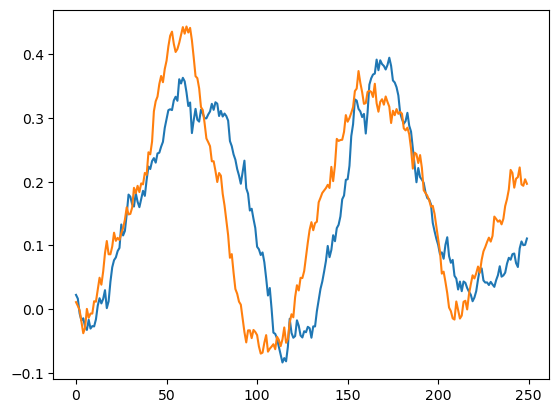

In [8]:
plt.plot(X[:, 0, :, 0]);

In [14]:
def_std = 0.1

model = pm.Model()
with model:
    model_a_star = pm.Normal(name="model_a_star", mu=0.0, sd=1.0, shape=sim.model.a.shape)
    model_a = pm.Deterministic(name="model_a", var=sim.model.a * (1.0 + def_std * model_a_star))
    
    coupling_a_star = pm.Normal(name="coupling_a_star", mu=0.0, sd=1.0)
    coupling_a = pm.Deterministic(name="coupling_a", 
                                  var=sim.coupling.a[0].item() * (1.0 + def_std * coupling_a_star))
    
    x_init_star = pm.Normal(name="x_init_star", mu=0.0, sd=1.0, 
                            shape=sim.initial_conditions.shape[:-1])
    x_init = pm.Deterministic(name="x_init", 
                              var=sim.initial_conditions[:, :, :, 0] * (1.0 + def_std*x_init_star))
    
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    nsig_star = BoundedNormal(name="nsig_star", mu=0.0, sd=1.0)
    nsig = pm.Deterministic(name="nsig", 
                            var=sim.integrator.noise.nsig[0].item() * (1.0 + def_std * nsig_star))
    
    dWt_star = pm.Normal(name="dWt_star", mu=0.0, sd=1.0, shape=X.shape[:-1])
    
    amplitude_star = pm.Normal(name="amplitude_star", mu=0.0, sd=1.0)
    amplitude = pm.Deterministic(name="amplitude", var=1.0 * (1.0 + def_std * amplitude_star))

    offset_star = pm.Normal(name="offset_star", mu=0.0, sd=1.0)
    offset = pm.Deterministic(name="offset", var=def_std * offset_star)
    
    observation_noise_star = pm.HalfNormal(name="observation_noise_star", sd=1.0)
    observation_noise = pm.Deterministic(name="observation_noise", var=def_std*observation_noise_star)
    

In [15]:
prior = Pymc3Prior(
    model=model,
    names=["model.a", "coupling.a", "x_init", "integrator.noise.nsig", "dWt_star", 
           "observation.model.amplitude", "observation.model.offset", "observation.noise"], 
    dist=[model_a, coupling_a, x_init, nsig, dWt_star, 
          amplitude, offset, observation_noise]
)

In [16]:
model_builder = StochasticPymc3ModelBuilder(sim=sim, params=prior, 
                                            observation_fun=linear, observation=X[:, :, :, 0])

In [17]:
model_builder.compose_model()

In [18]:
pymc_model = model_builder.build()

In [19]:
pymc_model.model

In [20]:
pymc_estimator = EstimatorPYMC(stats_model=pymc_model)

In [21]:
draws = 500
tune = 500
cores = 2

In [24]:
inference_data = pymc_estimator.run_inference(
    draws=draws, tune=tune, cores=cores, target_accept=0.9, max_treedepth=15)

/Users/erichter/opt/anaconda3/envs/tvb-inv-env/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...


07-12-2022 07:24:50 - INFO - pymc3 - Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


07-12-2022 07:24:50 - INFO - pymc3 - Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (2 chains in 2 jobs)


07-12-2022 07:25:01 - INFO - pymc3 - Multiprocess sampling (2 chains in 2 jobs)


NUTS: [observation_noise_star, offset_star, amplitude_star, dWt_star, nsig_star, x_init_star, coupling_a_star, model_a_star]


07-12-2022 07:25:01 - INFO - pymc3 - NUTS: [observation_noise_star, offset_star, amplitude_star, dWt_star, nsig_star, x_init_star, coupling_a_star, model_a_star]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 20134 seconds.


08-12-2022 01:00:36 - INFO - pymc3 - Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 20134 seconds.


There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


08-12-2022 01:00:42 - ERROR - pymc3 - There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


08-12-2022 01:00:42 - ERROR - pymc3 - There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.


08-12-2022 01:00:42 - INFO - pymc3 - The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.


The estimated number of effective samples is smaller than 200 for some parameters.


08-12-2022 01:00:42 - ERROR - pymc3 - The estimated number of effective samples is smaller than 200 for some parameters.


/Users/erichter/opt/anaconda3/envs/tvb-inv-env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/erichter/opt/anaconda3/envs/tvb-inv-env/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


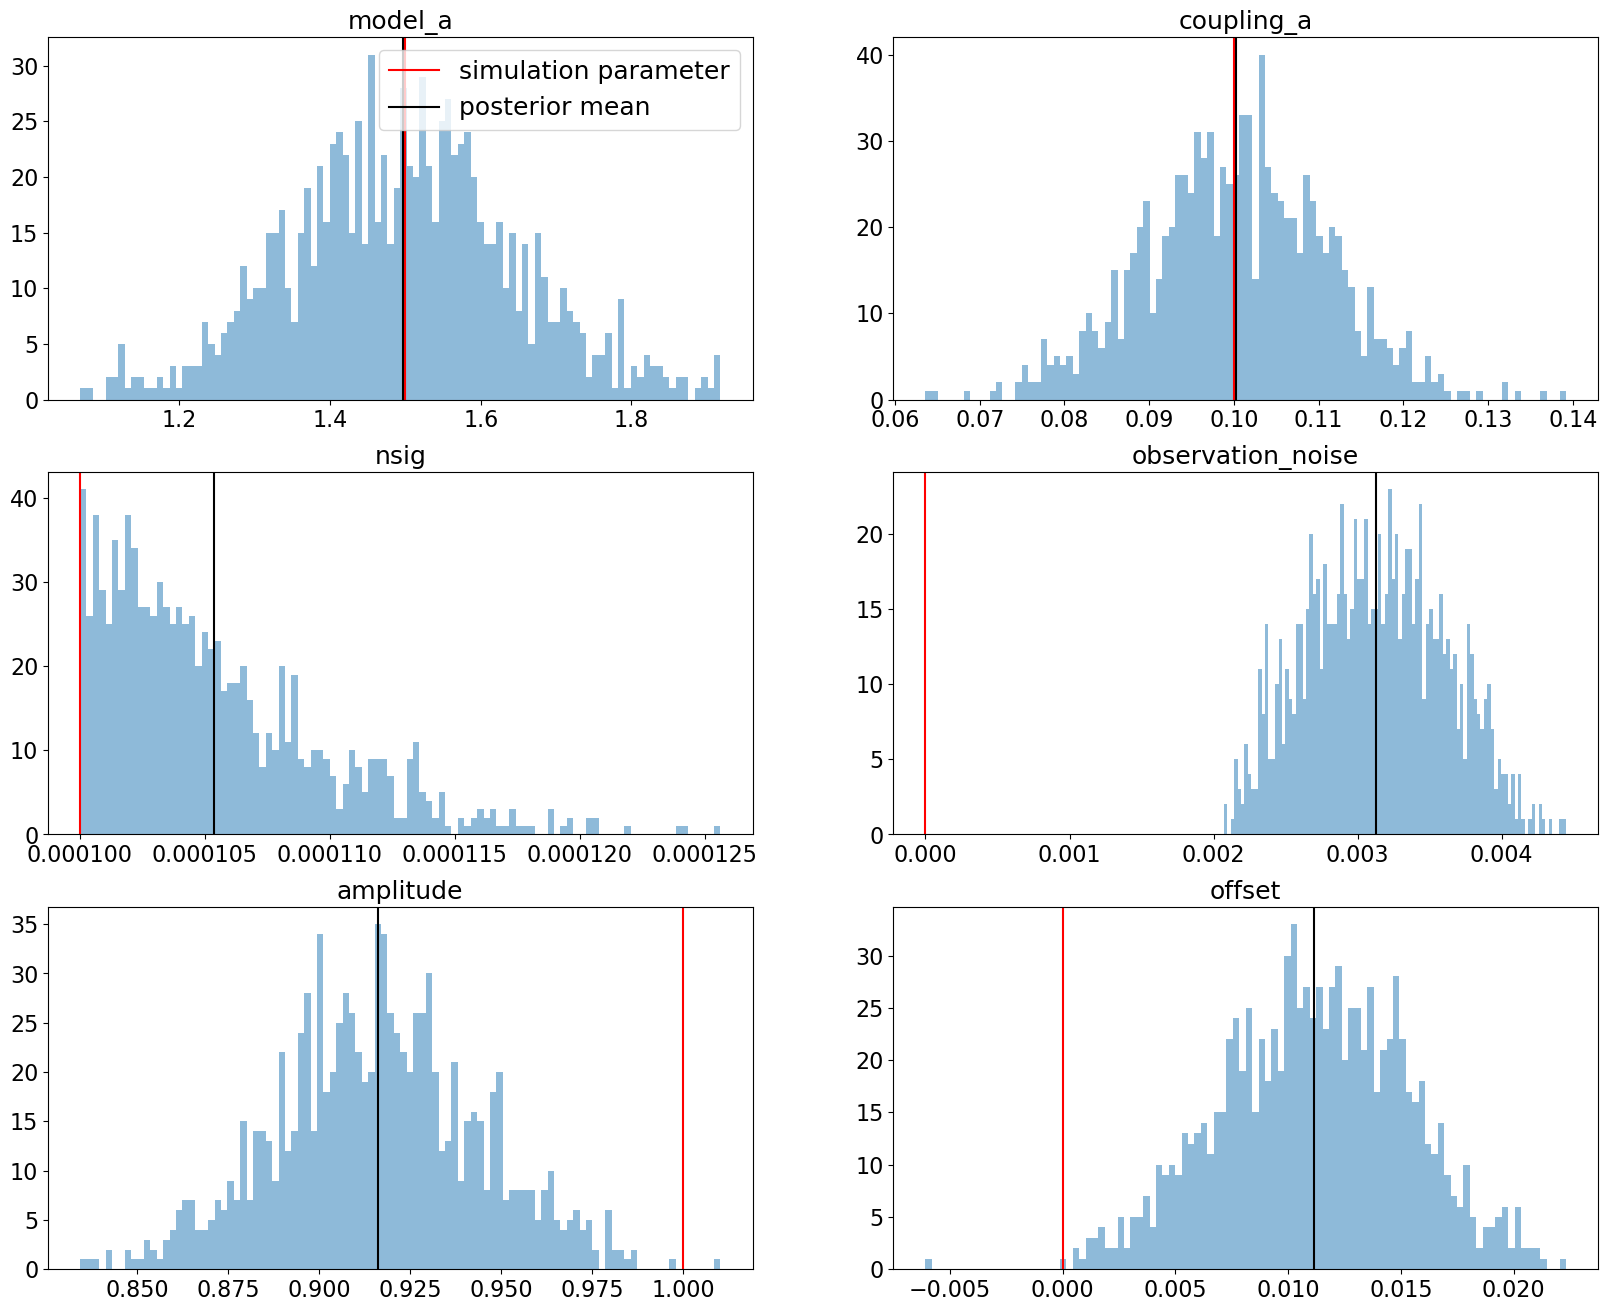

In [25]:
init_params = {
    "model_a": sim.model.a,
    "coupling_a": sim.coupling.a[0],
    "nsig": sim.integrator.noise.nsig[0],
    "observation_noise": 0.0,
    "amplitude": 1.0,
    "offset": 0.0
}
plot_posterior_samples(pymc_estimator.inference_data, init_params)

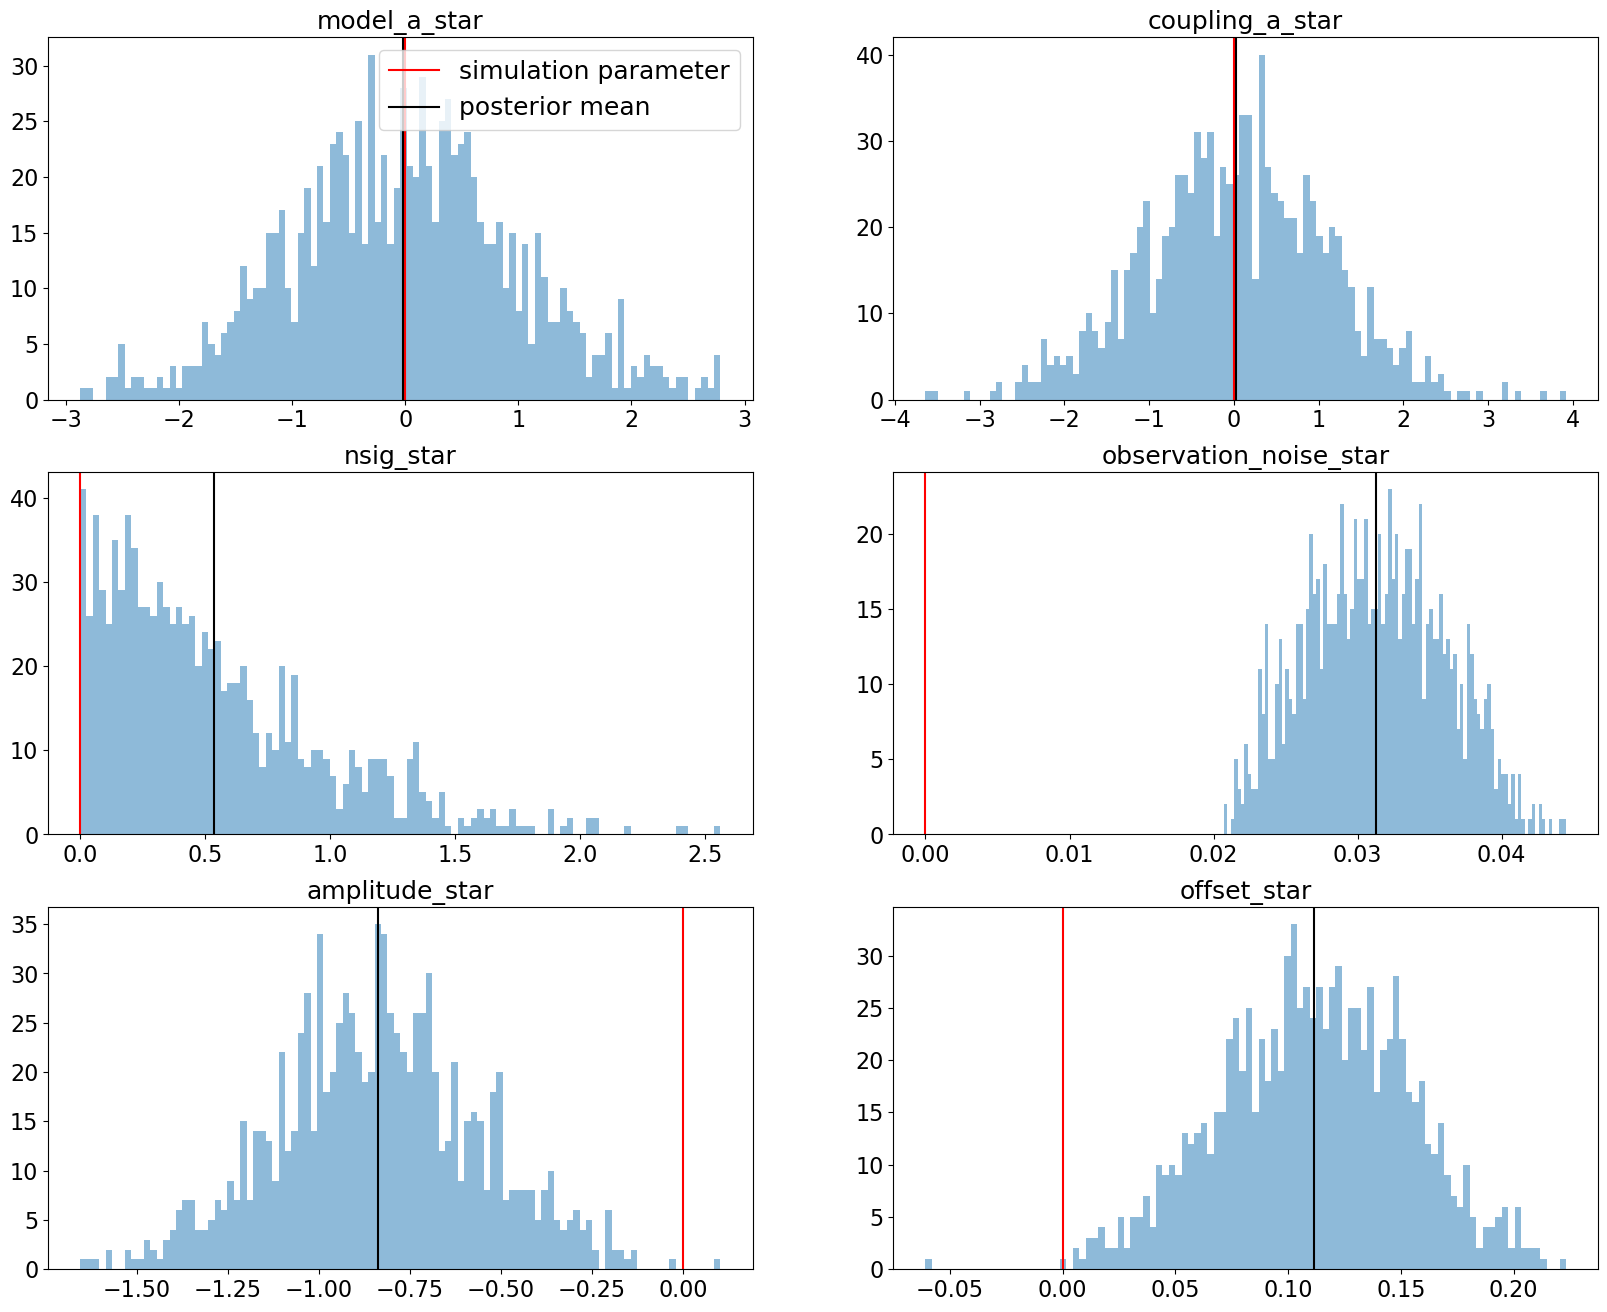

In [26]:
init_params = {
    "model_a_star": 0.0,
    "coupling_a_star": 0.0,
    "nsig_star": 0.0,
    "observation_noise_star": 0.0,
    "amplitude_star": 0.0,
    "offset_star": 0.0
}
plot_posterior_samples(pymc_estimator.inference_data, init_params)

In [29]:
_ = pymc_estimator.sample_posterior_predictive()
pymc_estimator.inference_data = pymc_estimator.get_inference_data()
pymc_estimator.inference_summary = pymc_estimator.get_inference_summary()

/Users/erichter/opt/anaconda3/envs/tvb-inv-env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/erichter/opt/anaconda3/envs/tvb-inv-env/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


In [30]:
posterior_x_obs = pymc_estimator.inference_data.posterior_predictive.x_obs.values.reshape(
    (cores*draws, *X.shape[:-1]))

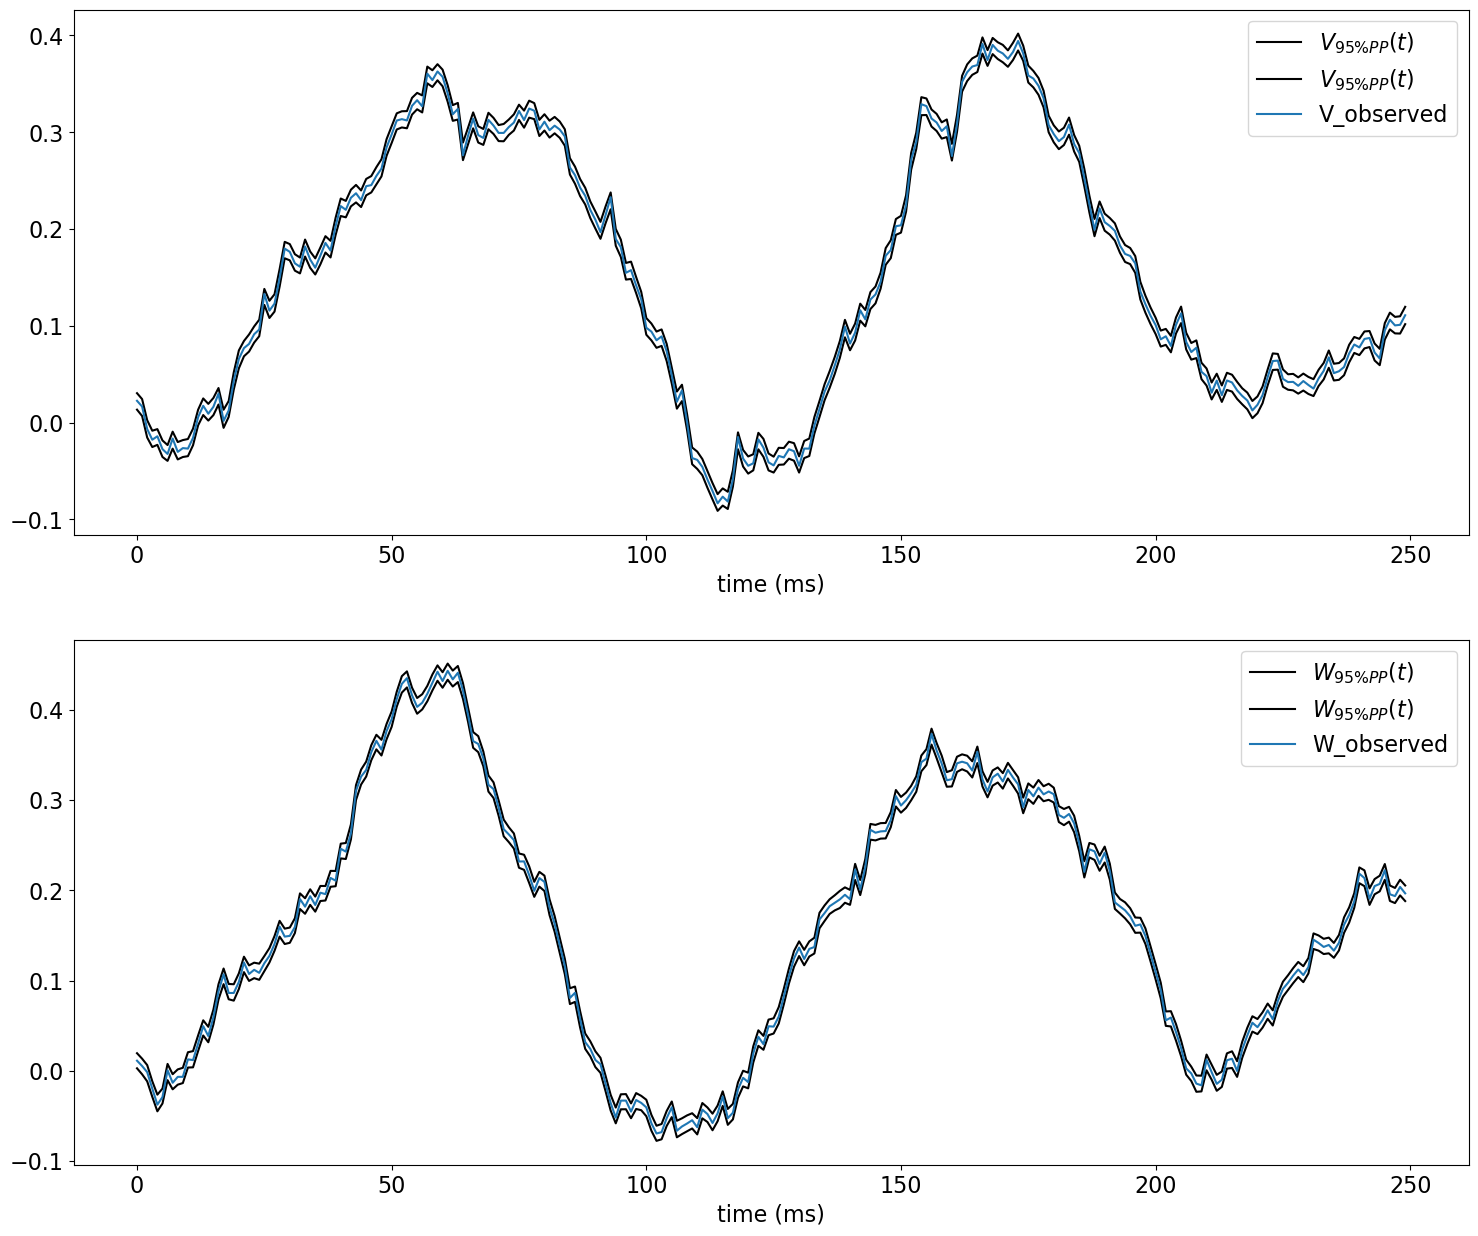

In [31]:
f3, axes3 = plt.subplots(nrows=2, ncols=1, figsize=(18,15))
axes3[0].plot(np.percentile(posterior_x_obs[:, :, 0, 0], [2.5, 97.5], axis=0).T, 
              "k", label=r"$V_{95\% PP}(t)$")
axes3[0].plot(X[:, 0, 0, 0], label="V_observed")
axes3[0].legend(fontsize=16)
axes3[0].set_xlabel("time (ms)", fontsize=16)
axes3[0].tick_params(axis="both", labelsize=16)

axes3[1].plot(np.percentile(posterior_x_obs[:, :, 0, 1], [2.5, 97.5], axis=0).T, 
         "k", label=r"$W_{95\% PP}(t)$")
axes3[1].plot(X[:, 0, 1, 0], label="W_observed")
axes3[1].legend(fontsize=16)
axes3[1].set_xlabel("time (ms)", fontsize=16)
axes3[1].tick_params(axis="both", labelsize=16)

plt.show()

In [32]:
pymc_estimator.inference_summary.loc[
    pymc_estimator.inference_summary.index.str.contains("model_a_star")].describe()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
count,1.000,1.000,1.0,1.000,1.000,1.000,1.0,1.0,1.0
mean,-0.024,1.012,-1.9,1.934,0.023,0.032,1898.0,852.0,1.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-0.024,1.012,-1.9,1.934,0.023,0.032,1898.0,852.0,1.0
25%,-0.024,1.012,-1.9,1.934,0.023,0.032,1898.0,852.0,1.0
50%,-0.024,1.012,-1.9,1.934,0.023,0.032,1898.0,852.0,1.0
75%,-0.024,1.012,-1.9,1.934,0.023,0.032,1898.0,852.0,1.0
max,-0.024,1.012,-1.9,1.934,0.023,0.032,1898.0,852.0,1.0


In [34]:
pymc_estimator.inference_summary.loc[
    ["model_a_star[0]", "coupling_a_star", "nsig_star", 
     "amplitude_star", "offset_star", "observation_noise_star"]]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
model_a_star[0],-0.024,1.012,-1.900,1.934,0.023,0.032,1898.0,852.0,1.00
coupling_a_star,0.020,1.082,-1.959,2.102,0.024,0.041,2077.0,489.0,1.01
nsig_star,0.537,0.440,0.001,1.339,0.016,0.012,794.0,483.0,1.00
amplitude_star,-0.838,0.279,-1.408,-0.341,0.026,0.018,117.0,341.0,1.01
offset_star,0.111,0.042,0.027,0.183,0.003,0.002,166.0,463.0,1.00
observation_noise_star,0.031,0.005,0.023,0.040,0.001,0.001,19.0,69.0,1.14


In [37]:
pymc_estimator.inference_summary.loc[
    ["model_a[0]", "coupling_a", "nsig", 
     "amplitude", "offset", "observation_noise"]]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
model_a[0],1.496,0.152,1.215,1.790,0.003,0.002,1898.0,852.0,1.00
coupling_a,0.100,0.011,0.080,0.121,0.000,0.000,2077.0,489.0,1.01
nsig,0.000,0.000,0.000,0.000,0.000,0.000,794.0,483.0,1.00
amplitude,0.916,0.028,0.859,0.966,0.003,0.002,117.0,341.0,1.01
offset,0.011,0.004,0.003,0.018,0.000,0.000,166.0,463.0,1.00
observation_noise,0.003,0.000,0.002,0.004,0.000,0.000,19.0,69.0,1.14


In [38]:
pymc_estimator.inference_summary.loc[
    pymc_estimator.inference_summary.index.str.contains("x_init_star")].describe()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,-0.005875,0.994000,-1.882375,1.831875,0.024000,0.036000,1807.375000,659.250000,1.002500
std,0.012811,0.045049,0.206941,0.146177,0.003817,0.004106,474.395536,113.504877,0.004629
min,-0.025000,0.928000,-2.193000,1.576000,0.019000,0.029000,1049.000000,516.000000,1.000000
25%,-0.012000,0.967000,-2.014750,1.771750,0.021000,0.033750,1573.000000,592.000000,1.000000
50%,-0.006500,0.996000,-1.892500,1.866500,0.024000,0.036000,1684.500000,623.000000,1.000000
75%,-0.001500,1.020500,-1.739000,1.926000,0.026000,0.039000,2189.250000,740.500000,1.002500
max,0.019000,1.056000,-1.576000,2.009000,0.031000,0.042000,2498.000000,840.000000,1.010000


In [39]:
pymc_estimator.inference_summary.loc[
    pymc_estimator.inference_summary.index.str.contains("dWt_star")].describe()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.027134,0.314991,-0.561233,0.615447,0.008237,0.007415,1552.916000,686.768000,1.004670
std,0.942075,0.011056,0.940784,0.940172,0.001490,0.002117,358.087506,118.532046,0.005738
min,-3.061000,0.281000,-3.668000,-2.447000,0.006000,0.004000,241.000000,260.000000,1.000000
25%,-0.592750,0.308000,-1.193250,-0.009000,0.007000,0.006000,1342.000000,604.000000,1.000000
50%,0.035000,0.315000,-0.538000,0.625500,0.008000,0.007000,1560.500000,695.500000,1.000000
75%,0.629250,0.322000,0.033250,1.213000,0.009000,0.008000,1765.500000,769.000000,1.010000
max,3.586000,0.371000,2.959000,4.163000,0.024000,0.019000,3000.000000,1030.000000,1.030000


In [40]:
pymc_estimator.inference_data.to_netcdf(
    filename="pymc3_data/20221208_2nodes_couplinga_modela.nc", compress=False)

'pymc3_data/20221208_2nodes_couplinga_modela.nc'